<a href="https://colab.research.google.com/github/saimasharleen/Active-Learning-Strategies-Across-Diverse-Machine-Learning-Models/blob/main/MNIST_logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-agcfiaki
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-agcfiaki
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.5 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=749234b72352fe4279fb3e2093a72ac5c8a3332c71e34726e1cf4b261a06bdae
  Stored in directory: /tmp/pip-ephem-wheel-cache-8io89ily/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [3]:
import modAL

In [4]:
#import the packages
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
import joblib
import collections
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [5]:
mnist_data = MNIST('.', download= True, transform = ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size = 60000 )
x, y = next(iter(dataloader))

x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=10000, random_state=0, stratify=y)
x_test=x_test.reshape(len(x_test), 1, 28, 28)

100%|██████████| 9912422/9912422 [00:00<00:00, 82100049.26it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31196418.70it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26549342.77it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3164014.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
#build the logistic regression model
from torch import nn
from skorch import NeuralNetClassifier
import torch
class Regression_Model(nn.Module):
    def __init__( self):
        super( Regression_Model , self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10))

    def forward(self, x):
        out = torch.sigmoid(self.fc(x))
        return out

In [7]:
# Wrap with Skorch for compatiblity with sklearn

classifier = NeuralNetClassifier(Regression_Model,
    criterion = nn.CrossEntropyLoss,
    optimizer = torch.optim.Adam,
    train_split = None,
    verbose = 1,
    lr=0.01,
    device = device,
    )

In [8]:
#the base model
import joblib
filename = "regression_version1.joblib"
joblib.dump(classifier, filename)
#loaded_model = joblib.load(filename)

['regression_version1.joblib']

In [9]:
def CF_Print(y_test, y_pred):
    accuracy = accuracy_score(y_pred, y_test)
    CF = confusion_matrix(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print('Confusion Matrix:')
    print(CF)
    print('Accuracy: ', accuracy)
    print('Macro F1-score: ', macro_f1)
    print('Micro F1-score: ', micro_f1)
    print('Weighted F1-score: ', weighted_f1)
    print("---------------------------------")

In [10]:
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial,  y_pool = train_test_split(x_train,y_train, train_size=n_initial, random_state=0, stratify=y_train)
    x_initial = x_initial.reshape(len(x_initial), 1, 28, 28)
    x_pool = x_pool.reshape(len(x_pool), 1, 28, 28)
    filename = "regression_version1.joblib"
    classifier = joblib.load(filename)
    learner = ActiveLearner(
        estimator = classifier,
        query_strategy = uncertainty_sampling,
        X_training = x_initial, y_training = y_initial, epochs=10,
    )
    print("No of initial data: ", n_initial)
    print(learner.score(x_test, y_test))
    y_pred = learner.predict(x_test)
    print('Confusion Matrix After trainig with initial data')
    CF_Print(y_test, y_pred)
    print("---- Train From Scratch with first model-----")
    AL_Train_Scratch(n_initial, learner)
    print("---- Teach/Retrain with new data-------")
    for idx in range(n_queries):
        print('--- Query no:  ', idx+1, ' ----')
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(
            X=x_pool[query_idx],
            y=y_pool[query_idx],
        )
        print('Instance', y_pool[query_idx] )
        print(learner.score(x_test, y_test))
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
    y_pred = learner.predict(x_test)
    print('Confusion Matrix After RE-TRAINGING')
    CF_Print(y_test, y_pred)

In [11]:
#Train the model from scratch based on the dataset selected by active learning method ensuring the uniform distribution of the data
def AL_Train_Scratch(n_initial, trained_learner):
    global x_train
    x_train_reshaped=x_train.reshape(len(x_train), 1, 28, 28)
    query_idx, query_instance = trained_learner.query(x_train_reshaped, n_instances=(n_initial*3))
    distribution=[0]*10
    flag=0
    data_per_class= int(n_initial/10)
    x_initial=[]
    y_initial=[]
    x_temp= x_train_reshaped[query_idx]
    y_temp=y_train[query_idx]
    for data, label in zip(x_temp, y_temp):
        if distribution[label]<data_per_class:
            x_initial.append(data)
            y_initial.append(label)
            distribution[label]+=1
            if distribution[label]==data_per_class:
                flag+=1
        if flag==10:
            break
    del x_temp, y_temp
    print(y_initial)
    counter = collections.Counter(y_initial)
    print(counter)
    filename = "regression_version1.joblib"
    classifier = joblib.load(filename)
    x_initial= np.array(x_initial)
    y_initial = np.array(y_initial)
    x_initial = x_initial.reshape(len(x_initial), 1, 28, 28)
    new_learner = ActiveLearner(
        estimator = classifier,
        query_strategy = uncertainty_sampling,
        X_training = x_initial, y_training = y_initial, epochs=10,
    )
    print(new_learner.score(x_test, y_test))
    y_pred = new_learner.predict(x_test)
    print("Confusion Matrix after training the model with most important dataset")
    CF_Print(y_test, y_pred)

In [12]:
AL_Retrain(30, 10, 20)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2944  0.0657
      2        2.1376  0.0043
      3        2.0110  0.0066
      4        1.9103  0.0129
      5        1.8272  0.0029
      6        1.7592  0.0027
      7        1.7049  0.0104
      8        1.6624  0.0028
      9        1.6292  0.0028
     10        1.6026  0.0029
No of initial data:  30
0.5236
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[784   2  14   5   9  52  97   0  23   1]
 [  0 905  21  99   5  20  25  46   3   0]
 [117 110 290  54  58 162 141  24  33   4]
 [ 34  36  11 381   4 397  34  31  76  18]
 [ 20  15  11  63 534   0  32  35  18 246]
 [164  17   7 107  33 253  93   5 140  84]
 [ 79  18  86   0  40   9 749   0   5   0]
 [ 28  31   1  30 204  12   1 482   3 252]
 [ 47 145  12 169  86  40  83  27 310  56]
 [ 10  10   8  70 207   5   7 110  17 548]]
Accuracy:  0.5236
Macro F1-score:  0.507511296443625
Micro F1-score:  0.5236
Weighted F1-score:  0.512588655618

In [13]:
AL_Retrain(30, 10, 30)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2996  0.0030
      2        2.1434  0.0024
      3        2.0174  0.0031
      4        1.9161  0.0030
      5        1.8320  0.0032
      6        1.7630  0.0027
      7        1.7078  0.0053
      8        1.6647  0.0044
      9        1.6308  0.0024
     10        1.6037  0.0023
No of initial data:  30
0.531
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[794   2  17   6   5  59  87   0  16   1]
 [  0 910  26 112   7  17  24  24   4   0]
 [112 104 309  54  52 175 130  23  32   2]
 [ 31  32  10 406   2 388  36  26  72  19]
 [ 22  11  10  49 587   0  29  26  19 221]
 [151  15  10 116  31 266  88   8 143  75]
 [ 80  14  92   0  51  13 733   0   3   0]
 [ 26  30   0  23 205  14   1 486   3 256]
 [ 38 126  12 180 100  46  65  26 314  68]
 [ 11  10  15  73 238   4   5 107  24 505]]
Accuracy:  0.531
Macro F1-score:  0.516939981152115
Micro F1-score:  0.531
Weighted F1-score:  0.522126869583647

In [14]:
AL_Retrain(50, 10, 20)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2898  0.0022
      2        2.1418  0.0025
      3        2.0251  0.0024
      4        1.9295  0.0026
      5        1.8501  0.0028
      6        1.7864  0.0028
      7        1.7369  0.0027
      8        1.6977  0.0025
      9        1.6653  0.0038
     10        1.6378  0.0025
No of initial data:  50
0.5966
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[820   4  17   7   3  25  80   0  13  18]
 [  0 927  24 149   1   3   5   4  11   0]
 [148  97 359  56  43  23 113  19 123  12]
 [ 23  28  14 437   4 348  23  16 107  22]
 [  9  20   6  24 634   0  10  52  16 203]
 [124  25  11 137  35 229  62   6 203  71]
 [ 52  46  61   1  18  16 780   1  10   1]
 [  7  51   3  21  90   4   1 687   2 178]
 [ 47  80  13 102  25  15  42  16 579  56]
 [  6  17   3  39 202   3   0 201   7 514]]
Accuracy:  0.5966
Macro F1-score:  0.5813533250032935
Micro F1-score:  0.5966
Weighted F1-score:  0.58617433262

In [15]:
AL_Retrain(50, 10, 30)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3050  0.0022
      2        2.1519  0.0034
      3        2.0298  0.0030
      4        1.9324  0.0034
      5        1.8529  0.0033
      6        1.7889  0.0023
      7        1.7384  0.0023
      8        1.6985  0.0033
      9        1.6659  0.0033
     10        1.6385  0.0021
No of initial data:  50
0.5926
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[803   4  27   7   3  31  80   1  14  17]
 [  0 933  19 147   0   2   7   3  13   0]
 [121 104 365  46  47  39 121  18 122  10]
 [ 19  32   8 428   5 340  23  20 124  23]
 [  6  22   6  21 616   0  17  70  14 202]
 [113  33  14 135  37 206  58  13 225  69]
 [ 54  50  63   0  13  11 785   0  10   0]
 [  8  55   4  25  90   1   1 705   3 152]
 [ 35  93  16  81  29  17  50  17 584  53]
 [  4  18   2  39 206   4   0 210   8 501]]
Accuracy:  0.5926
Macro F1-score:  0.576153371470215
Micro F1-score:  0.5926
Weighted F1-score:  0.581155800484

In [16]:
AL_Retrain(100, 10, 20)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2977  0.0027
      2        2.1675  0.0033
      3        2.0622  0.0034
      4        1.9773  0.0033
      5        1.9064  0.0037
      6        1.8480  0.0030
      7        1.8012  0.0034
      8        1.7637  0.0036
      9        1.7326  0.0029
     10        1.7059  0.0029
No of initial data:  100
0.6967
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[832   2  19   2   1  65  54   0   8   4]
 [  0 996  12  17   1  15   3   1  79   0]
 [ 58  25 705  11  16  28  35   7 105   3]
 [ 31  28  58 442   5 275  22  11 142   8]
 [  9  13  16   3 829   7   7   7  32  51]
 [ 67   7  22 100  28 448  32   1 159  39]
 [ 26  24  63   0   4  78 791   0   0   0]
 [ 18  19   5  40 125   5   3 691  46  92]
 [ 30  47  42  26  22  33  18   5 735  17]
 [ 17  10  16  35 315   7   0  63  31 498]]
Accuracy:  0.6967
Macro F1-score:  0.689493989480441
Micro F1-score:  0.6967
Weighted F1-score:  0.69346353824

In [17]:
AL_Retrain(100, 10, 30)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3156  0.0026
      2        2.1860  0.0038
      3        2.0810  0.0041
      4        1.9942  0.0038
      5        1.9203  0.0034
      6        1.8592  0.0033
      7        1.8108  0.0034
      8        1.7724  0.0036
      9        1.7404  0.0031
     10        1.7127  0.0031
No of initial data:  100
0.6956
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[838   3  18   3   1  66  49   0   6   3]
 [  0 988   7  16   0  26   2   1  83   1]
 [ 59  26 685   9  15  34  44   3 115   3]
 [ 32  36  50 462   6 250  19  10 148   9]
 [  9  13  15   2 821   8   5   7  34  60]
 [ 56   9  14 111  30 437  30   2 181  33]
 [ 28  26  63   0   6  80 783   0   0   0]
 [ 17  23   5  41 118   6   3 680  43 108]
 [ 23  55  41  40  26  31  14   4 726  15]
 [ 17  15  13  28 294   6   1  51  31 536]]
Accuracy:  0.6956
Macro F1-score:  0.689869071501459
Micro F1-score:  0.6956
Weighted F1-score:  0.69375118995

In [18]:
AL_Retrain(300, 10, 20)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2494  0.0067
      2        1.9828  0.0072
      3        1.8457  0.0079
      4        1.7722  0.0082
      5        1.7267  0.0076
      6        1.6954  0.0076
      7        1.6720  0.0075
      8        1.6536  0.0105
      9        1.6386  0.0094
     10        1.6261  0.0095
No of initial data:  300
0.7852
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[ 894    2    6    5    0   11   42    0   25    2]
 [   0 1054   18   10    1   12    2    3   24    0]
 [  29   19  782   21    6    0   44   14   66   12]
 [  13   38   56  756    0   53   18   20   47   21]
 [   8   10   14    1  615    1   26    8   26  265]
 [  39   27   16   99   17  541   29    5   96   34]
 [  21   19   56    0    0   22  858    0   10    0]
 [  21   22    8   11   10    0    1  848   22  101]
 [  26   63   19   69    5   26   13    4  721   29]
 [  13   11    9   14   41    5    1   85   30  783]]
Accuracy: 

In [19]:

AL_Retrain(300, 10, 30)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2482  0.0072
      2        1.9808  0.0089
      3        1.8464  0.0109
      4        1.7720  0.0096
      5        1.7273  0.0072
      6        1.6958  0.0073
      7        1.6723  0.0079
      8        1.6543  0.0086
      9        1.6394  0.0083
     10        1.6270  0.0082
No of initial data:  300
0.7847
Confusion Matrix After trainig with initial data
Confusion Matrix:
[[ 895    3    8    6    0    9   41    0   24    1]
 [   0 1056   17   10    1   11    2    2   25    0]
 [  29   20  784   20    7    0   44   15   64   10]
 [  13   39   58  755    0   53   17   20   47   20]
 [   9   10   12    2  607    0   28    8   25  273]
 [  39   31   16  102   15  548   27    5   87   33]
 [  22   22   53    0    0   22  857    0   10    0]
 [  22   23    8   11    8    0    2  832   25  113]
 [  28   64   22   69    5   22   13    2  720   30]
 [  10   10    9   15   31    5    1   86   32  793]]
Accuracy: 

  epoch    train_loss     dur
-------  ------------  ------
      1        2.3072  0.0032
      2        2.1507  0.0028
      3        2.0223  0.0026
      4        1.9191  0.0041
      5        1.8342  0.0027
      6        1.7648  0.0028
      7        1.7094  0.0038
      8        1.6661  0.0027
      9        1.6322  0.0025
     10        1.6050  0.0028
Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        2.2984  0.0033
      2        2.0950  0.0042
      3        2.0307  0.0033
      4        1.9872  0.0033
      5        1.9443  0.0035
      6        1.9008  0.0032
      7        1.8568  0.0033
      8        1.8159  0.0037
      9        1.7820  0.0031
     10        1.7542  0.0050
Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        2.2883  0.0041
      2        2.1268  0.0052
      3        2.0597  0.0051
      4        2.0099  0.002

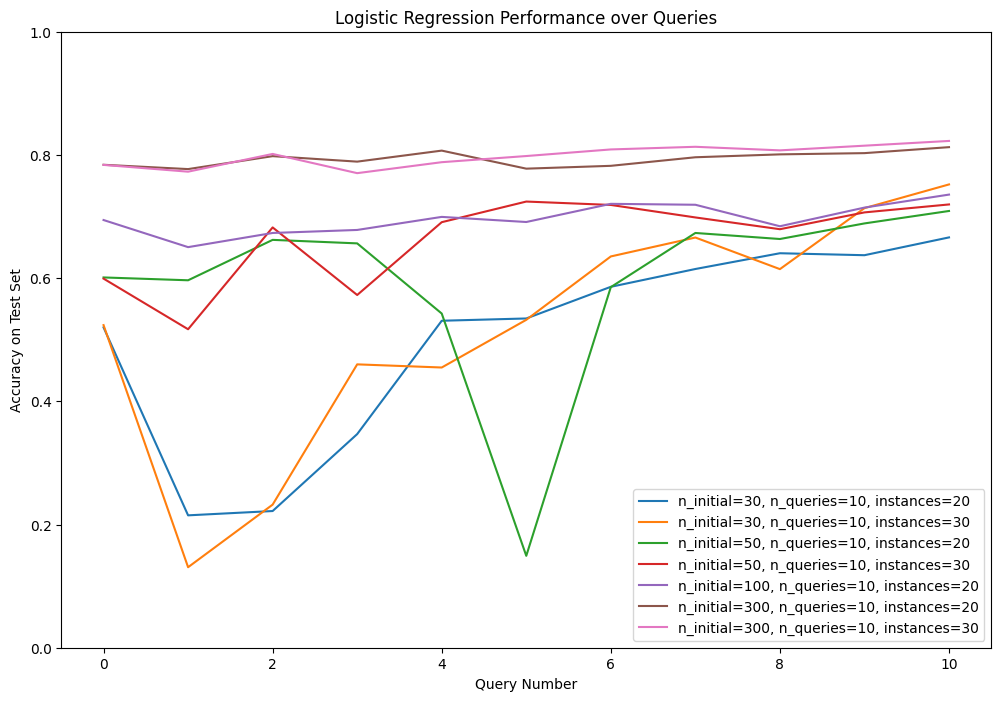

In [22]:
import matplotlib.pyplot as plt

# AL_Retrain function with performance tracking
def AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test):
    # Splitting initial training data
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)
    x_initial = x_initial.reshape(len(x_initial), 1, 28, 28)
    x_pool = x_pool.reshape(len(x_pool), 1, 28, 28)

    # Load the logistic regression model
    filename = "regression_version1.joblib"
    classifier = joblib.load(filename)

    # Initialize Active Learner
    learner = ActiveLearner(
        estimator=classifier,
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial, epochs=10
    )

    # Track the performance after each query
    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Record the new performance
        new_score = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(new_score)

    return performance_history

# Define the configurations
configurations = [
    (30, 10, 20),
    (30, 10, 30),
    (50, 10, 20),
    (50, 10, 30),
    (100, 10, 20),
    (300, 10, 20),
    (300, 10, 30)
]

# Run and plot each configuration
plt.figure(figsize=(12, 8))
for config in configurations:
    n_initial, n_queries, instances = config
    performance_history = AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test)
    plt.plot(performance_history, label=f'n_initial={n_initial}, n_queries={n_queries}, instances={instances}')

plt.title("Logistic Regression Performance over Queries")
plt.xlabel("Query Number")
plt.ylabel("Accuracy on Test Set")
plt.legend()
plt.ylim(0, 1)
plt.show()
